# LightFM -  hybrid matrix factorisation on MovieLens (Python, CPU)

## Notes
Last updated: 23-04-23

TO-DO:
- update movielens in reco_utils to retrieve and join user metadata
- extract model outputs to assess performance with ndcg_at_k

This notebook explains the concept of a hybrid matrix factorisation based model for recommendation, it also outlines the steps to construct a pure matrix factorisation and a hybrid models using the [LightFM](https://github.com/lyst/lightfm) package. It also demonstrates how to extract both user and item affinity from a fitted hybrid model.

## 1. Hybrid matrix factorisation model

### 1.1 Background

In general, most recommendation models can be divided into two categories:
- Content based model,
- Collaborative filtering model.

The content-based model recommends based on similarity of the items and/or users using their description/metadata/profile. On the other hand, collaborative filtering model (discussion is limited to matrix factorisation approach in this notebook) computes the latent factors of the users and items. It works based on the assumption that if a group of people expressed similar opinions on an item, these peole would tend to have similar opinions on other items. For further background and detailed explanation between these two approaches, the reader can refer to machine learning literatures [3, 4].

The choice between the two models is largely based on the data availability. For example, the collaborative filtering model is usually adopted and effective when sufficient ratings/feedbacks have been recorded for a group of users and items.

However, if there is a lack of ratings, content based model can be used provided that the metadata of the users and items are available. This is also the common approach to address the cold-start issues, where there are insufficient historical collaborative interactions available to model new users and/or items.

<!-- In addition, most collaborative filtering models only consume explicit ratings e.g. movie 

**NOTE** add stuff about implicit and explicit ratings -->

### 1.2 Hybrid matrix factorisation algorithm

In view of the above problems, there have been a number of proposals to address the cold-start issues by combining both content-based and collaborative filtering approaches. The hybrid matrix factorisation model is among one of the solutions proposed [1].  

In general, most hybrid approaches proposed different ways of assessing and/or combining the feature data in conjunction with the collaborative information.

### 1.3 LightFM package 

LightFM is a Python implementation of a hybrid recommendation algorithms for both implicit and explicit feedbacks [1].

It is a hybrid content-collaborative model which represents users and items as linear combinations of their content features’ latent factors. The model learns **embeddings or latent representations of the users and items in such a way that it encodes user preferences over items**. These representations produce scores for every item for a given user; items scored highly are more likely to be interesting to the user.

The user and item embeddings are estimated for every feature, and these features are then added together to be the final representations for users and items. 

For example, for user i, the model retrieves the i-th row of the feature matrix to find the features with non-zero weights. The embeddings for these features will then be added together to become the user representation e.g. if user 10 has weight 1 in the 5th column of the user feature matrix, and weight 3 in the 20th column, the user 10’s representation is the sum of embedding for the 5th and the 20th features multiplying their corresponding weights. The representation for each items is computed in the same approach. 

#### 1.3.1 Modelling approach

Let $U$ be the set of users and $I$ be the set of items, and each user can be described by a set of user features $f_{u} \subset F^{U}$ whilst each items can be described by item features $f_{i} \subset F^{I}$. Both $F^{U}$ and $F^{I}$ are all the features which fully describe all users and items. 

The LightFM model operates based binary feedbacks, the ratings will be normalised into two groups. The user-item interaction pairs $(u,i) \in U\times I$ are the union of positive (favourable reviews) $S^+$ and negative interactions (negative reviews) $S^-$ for explicit ratings. For implicit feedbacks, these can be the observed and not observed interactions respectively.

For each user and item feature, their embeddings are $e_{f}^{U}$ and $e_{f}^{I}$ respectively. Furthermore, each feature is also has a scalar bias term ($b_U^f$ for user and $b_I^f$ for item features). The embedding (latent representation) of user $u$ and item $i$ are the sum of its respective features’ latent vectors:

\begin{equation}
    q_u = \sum_{j \in f_u} e_{j}^{U}
\end{equation}

\begin{equation}
    p_i = \sum_{j \in f_i} e_{j}^{I}
\end{equation}

Similarly the biases for user $u$ and item $i$ are the sum of its respective bias vectors:

\begin{equation}
    b_u = \sum_{j \in f_u} b_{j}^{U}
\end{equation}

\begin{equation}
    b_i = \sum_{j \in f_i} b_{j}^{I}
\end{equation}

In LightFM, the representation for each user/item is a linear weighted sum of its feature vectors.

The prediction for user $u$ and item $i$ can be modelled as sigmoid of the dot product of user and item vectors, adjusted by its feature biases as follows:

\begin{equation}
    \hat{r}_{ui} = \sigma (q_u · p_i + b_u + b_i)
\end{equation}

As the LightFM is constructed to predict binary outcomes e.g. $S^+$ and $S^-$, the function $\sigma()$ is based on the [sigmoid function](https://mathworld.wolfram.com/SigmoidFunction.html). 

The LightFM algorithm estimates interaction latent vectors and bias for features. For model fitting, the cost function of the model consists of maximising the likelihood of data conditional on the parameters described above using stochastic gradient descent. The likelihood can be expressed as follows:

\begin{equation}
   L = \prod_{(u,i) \in S+}\hat{r}_{ui} \times \prod_{(u,i) \in S-}1 - \hat{r}_{ui}
\end{equation}

Note that if the feature latent vectors are not available, the algorithm will be behaves like a [logistic matrix factorisation model](http://stanford.edu/~rezab/nips2014workshop/submits/logmat.pdf).

## 2. Movie recommender with LightFM using only explicit feedbacks

### 2.1 Import libraries

In [27]:
import sys
sys.path.append("../../")
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightfm

# default number of recommendations
k = 10
# percentage of data used for testing
test_percentage = 0.25
# model learning rate
learning_rate = 0.25
# no of latent factors
no_components = 50
# no of epochs to fit model
no_epochs = 250
# no of threads to fit model
no_threads = 8
# regularisation for both user and item features
item_alpha=1e-6
user_alpha=1e-6

# seed for pseudonumber generations
seedno = 42

In [2]:
from reco_utils.dataset import movielens
from reco_utils.recommender.lightfm.lightfm_utils import (
    model_perf_plots, compare_metric, track_model_metrics, 
    similar_users, similar_items)

In [3]:
print("System version: {}".format(sys.version))
print("LightFM version: {}".format(lightfm.__version__))

System version: 3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
LightFM version: 1.15


### 2.2 Retrieve data

In [4]:
# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'

In [5]:
data = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    genres_col='genre',
    header=["userID", "itemID", "rating"]
)
# quick look at the data
data.sample(5)

100%|██████████| 4.81k/4.81k [00:01<00:00, 3.22kKB/s]


,userID,itemID,rating,genre
73929,493,763,4.0,Comedy
36882,535,508,5.0,Drama
51430,360,187,4.0,Action|Crime|Drama
16070,665,328,4.0,Action|Mystery|Romance|Thriller
97060,116,1254,2.0,Comedy


### 2.3 Prepare data

Before fitting the LightFM model, we need to create an instance of `Dataset` which holds the interaction matrix.

In [6]:
from lightfm.data import Dataset
dataset = Dataset()

The `fit` method creates the user/item id mappings.

In [7]:
dataset.fit(users=data['userID'], 
            items=data['itemID'])

# quick check to determine the number of unique users and items in the data
num_users, num_topics = dataset.interactions_shape()
print(f'Num users: {num_users}, num_topics: {num_topics}.')

Num users: 943, num_topics: 1682.


Next is to build the interaction matrix. The `build_interactions` method returns 2 COO sparse matrices, namely the `interactions` and `weights` matrices.

In [8]:
(interactions, weights) = dataset.build_interactions(data.iloc[:, 0:3].values)

LightLM works slightly differently compared to other packages as it expects the train and test sets to have same dimension. Therefore the conventional train test split will not work.

The package has included the `cross_validation.random_train_test_split` method to split the interaction data and splits it into two disjoint training and test sets. 

However, note that **it does not validate the interactions in the test set to guarantee all items and users have historical interactions in the training set**. Therefore this may result into a partial cold-start problem in the test set.

In [9]:
from lightfm import cross_validation
train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions, test_percentage=test_percentage,
    random_state=np.random.RandomState(seedno))

Double check the size of both the train and test sets.

In [10]:
print(f"Shape of train interactions: {train_interactions.shape}")
print(f"Shape of test interactions: {test_interactions.shape}")

Shape of train interactions: (943, 1682)
Shape of test interactions: (943, 1682)


### 2.4 Fit & evaluate the LightFM model

In this notebook, the LightFM model will be using the weighted Approximate-Rank Pairwise (WARP) as the loss. Further explanation on the topic can be found [here](https://making.lyst.com/lightfm/docs/examples/warp_loss.html#learning-to-rank-using-the-warp-loss).


In general, it maximises the rank of positive examples by repeatedly sampling negative examples until a rank violation has been located. This approach is recommended when only positive interactions are present.

In [11]:
from lightfm import LightFM

model1 = LightFM(loss='warp', no_components=no_components, 
                 learning_rate=learning_rate,                 
                 random_state=np.random.RandomState(seedno))

The performance of the model will be tracked using 3 metrics, namely: AUC, Precision and Recall. The progression of these metrics during the fitting process is shown as follows:

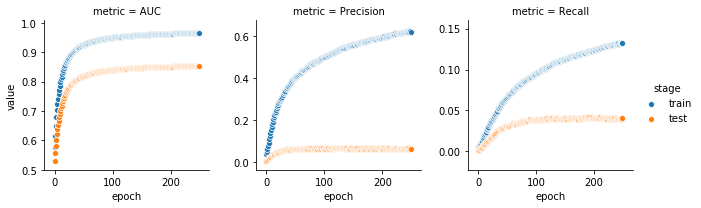

In [12]:
output1 = track_model_metrics(model=model1, 
                              train_interactions=train_interactions, 
                              test_interactions=test_interactions, k=k,
                              no_epochs=no_epochs, no_threads=no_threads)

Based on the model's AUC score, it seems the model is levelling off its performance quite early on ~50 epochs. The model then slowly improves as training progresses. As there is a gap between training and testing AUC, 

However, referring to both the Precision and Recall metric, the test performance in both cases plateaued out fairly early on, suggesting the model might be overfitting.

There are a few approaches to fix this (not part of objectives in this notebook) such as:
- changing model parameters,
- include more data.

## 3. Movie recommender with LightFM using explicit feedbacks and additional item and user features

As the LightFM was designed to incorporates both user and item metadata, the model can be extended to include additional features such as movie genres and user occupations.

### 3.1 Extract and prepare movie genres

In this notebook, the movie's genres will be used as the item metadata. As the genres have already been loaded during the initial data import, it can be processed directly as follows:

In [13]:
# split the genre based on the separator
movie_genre = [x.split('|') for x in data['genre']]

In [14]:
# retrieve the all the unique genres in the data
import itertools
all_movie_genre = sorted(list(set(itertools.chain.from_iterable(movie_genre))))
# quick look at the all the genres within the data
all_movie_genre

['Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western',
 'unknown']

### 3.2 Retrieve and prepare movie genres

Further user features can be included as part of the model fitting process. In this notebook, **only the occupation of each user will be included** but the feature list can be extended easily.


#### 3.2.1 Retrieve and merge data

The user features can be retrieved directly from the grouplens website and merged with the existing data as follows:

In [15]:
user_feature_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.user'
user_data = pd.read_table(user_feature_URL, 
              sep='|', header=None)
user_data.columns = ['userID','age','gender','occupation','zipcode']

# merging user feature with existing data
new_data = data.merge(user_data[['userID','occupation']], left_on='userID', right_on='userID')
# quick look at the merged data
new_data.sample(5)

,userID,itemID,rating,genre,occupation
47027,184,220,3.0,Comedy|Romance,librarian
42689,314,806,4.0,Action|Crime|Drama,student
78947,671,298,4.0,Action|Sci-Fi|Thriller,programmer
2772,439,307,3.0,Crime|Horror|Mystery|Thriller,administrator
70536,447,926,3.0,Comedy,administrator


#### 3.2.2 Extract and prepare user occupations

In [16]:
# retrieve all the unique occupations in the data
all_occupations = sorted(list(set(new_data['occupation'])))

### 3.3 Prepare data and features

Similar to the previous model, the data is required to be converted into a `Dataset` instance and then create a user/item id mapping with the `fit` method.

In [17]:
dataset2 = Dataset()
dataset2.fit(data['userID'], 
            data['itemID'], 
            item_features=all_movie_genre,
            user_features=all_occupations)

The movie genres are then converted into a item feature matrix using the `build_item_features` method as follows:

In [18]:
item_features = dataset2.build_item_features(
    (x, y) for x,y in zip(data.itemID, movie_genre))

The user occupations are then converted into an user feature matrix using the `build_user_features` method as follows:

In [19]:
user_features = dataset2.build_user_features(
    (x, [y]) for x,y in zip(new_data.userID, new_data['occupation']))

Once the item and user features matrices have been completed, the next steps are similar as before, which is to build the interaction matrix and split the interactions into train and test sets as follows:

In [20]:
(interactions2, weights) = dataset2.build_interactions(data.iloc[:, 0:3].values)

train_interactions2, test_interactions2 = cross_validation.random_train_test_split(
    interactions2, test_percentage=test_percentage,
    random_state=np.random.RandomState(seedno))

### 3.3 Fit & evaluate the LightFM model with additional user and item features

The parameters of the second model will be similar to the first model to facilitates comparison.

The model performance at each epoch is also tracked by the same metrics as before.

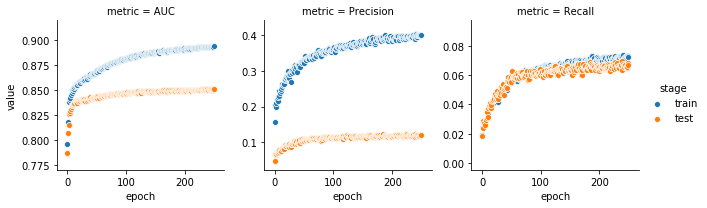

In [21]:
model2 = LightFM(loss='warp', no_components=no_components, 
                 learning_rate=learning_rate, 
                 item_alpha=item_alpha,
                 user_alpha=user_alpha,
                 random_state=np.random.RandomState(seedno))

output2 = track_model_metrics(model=model2, train_interactions=train_interactions2, 
                              test_interactions=test_interactions2, k=k,
                              no_epochs=no_epochs, no_threads=no_threads, 
                              item_features=item_features,
                              user_features=user_features)

Referring to the AUC figure above, it is rather interesting to see that with the inclusive of both user and item features, the model seems to have overfitted.

On the other hand, the Precision and Recall traces have plateued fairly early on, in particular for Precision@K there seems to be a large difference between train and test results. This could be due to the different number of user-item interactions between these data sets, e.g. the number of user-item interactions in the test set is less than the train set such that if the available interactions were less than K (in this case K=10), the best Precision@K will be bounded by the maximum number of interactions over K.

## 4. Performance comparison

As more features were included in this model, we can check whether movie genres actually helped in lifting the model's performance. The following plots look at the performance between the three models based on the test data set.

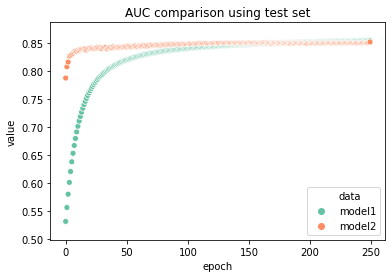

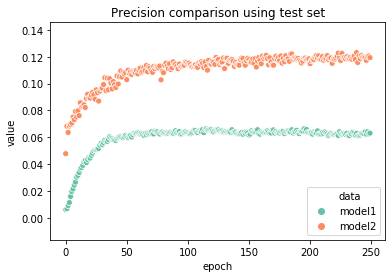

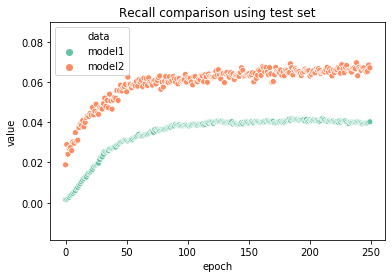

In [22]:
for i in ['AUC', 'Precision', 'Recall']:
    sns.set_palette("Set2")
    plt.figure()
    sns.scatterplot(x="epoch", y="value", hue='data',
                data=compare_metric(df_list = [output1, output2], metric=i)
               ).set_title(f'{i} comparison using test set');

From the AUC metric plots above, the model2 (with additional user and movie metadata) started with better AUC but regresses as model fit progresses perhaps due to the fact WARP loss function was used. It prioritises the top items on the list of recommendations, hence sacrificing global metrics such as AUC which measures overall ranking.

These can be evidenced by the Precision and Recall traces of model2, which are consistently better than model1. Note that model1 was essentially operating as a pure logistic matrix factorisation based model and interestingly from both Precision and Recall perspectives, the model1 seems to be experiencing variance issues as model fitting progresses.

Readers who are interested could further investigate parameters such as learning rate and/or regularisation penalty as these preliminary models would certainly benefit from further hyperparameter studies.

## 5. Similar users and items

As the LightFM package operates based on latent embeddings, these can be retrieved once the model has been fitted to assess user-user and/or item-item affinity.

### 5.1 User affinity

The user-user affinity can be retrieved with the `get_user_representations` method from the fitted model as follows:

In [23]:
_, user_embeddings = model2.get_user_representations(features=user_features)
user_embeddings

array([[-4.600731  , -2.086496  , -1.9594272 , ..., -3.0474017 ,
         0.5736157 ,  1.6404908 ],
       [-4.2404933 , -0.91970795, -0.9150321 , ..., -1.2648904 ,
         1.082889  , -3.7085075 ],
       [ 2.010844  , -0.5445101 ,  0.61061156, ...,  0.43452498,
        -1.6303868 , -2.080165  ],
       ...,
       [-4.031701  , -2.0082603 ,  5.110075  , ..., -4.1445317 ,
         1.8416774 , -3.0795944 ],
       [-4.0964794 , -0.8856952 , -0.766807  , ..., -1.4016649 ,
         0.9789169 , -3.5315475 ],
       [-4.3288956 , -1.2087252 ,  2.0176954 , ..., -1.669345  ,
         0.45913005, -1.9733078 ]], dtype=float32)

In order to retrieve the top N similar users, we can use the `similar_users` from `reco_utils`. For example, if we want to choose top 10 users most similar to the user 1:

In [24]:
similar_users(user_id=1, user_features=user_features, 
            model=model2)

,userID,score
0,555,0.999982
1,54,0.999975
2,314,0.999936
3,881,0.999905
4,411,0.999892
5,465,0.999889
6,851,0.999886
7,481,0.999881
8,395,0.999872
9,57,0.999870


### 5.2 Item affinity

Similar to the user affinity, the item-item affinity can be retrieved with the `get_item_representations` method using the fitted model.

In [25]:
_, item_embeddings = model2.get_item_representations(features=item_features)
item_embeddings

array([[-0.38332695, -0.50603884, -0.22805443, ...,  0.349333  ,
         0.9612321 , -0.32681438],
       [-0.19469026, -0.13599883,  0.2956012 , ..., -0.20422842,
         0.3438787 , -0.40283248],
       [-0.324097  , -0.5095233 , -0.18530415, ..., -0.20187879,
         0.5816436 , -0.26939964],
       ...,
       [-0.09070155, -0.0314341 ,  0.15465681, ..., -0.18998976,
        -0.04277764, -0.1616391 ],
       [-0.2581006 , -0.18313505,  0.34173757, ..., -0.46600726,
         0.0104358 , -0.15638116],
       [-0.1745196 , -0.17348903,  0.19153993, ..., -0.30927223,
         0.3188366 , -0.25172907]], dtype=float32)

The function to retrieve the top N similar items is similar to similar_users() above. For example, if we want to choose top 10 items most similar to the item 10:

In [26]:
similar_items(item_id=10, item_features=item_features, 
            model=model2)

,itemID,score
0,417,0.990190
1,352,0.985988
2,1092,0.982848
3,531,0.982603
4,65,0.980974
5,159,0.979775
6,556,0.979608
7,521,0.977361
8,622,0.977113
9,106,0.975191


## 6. Conclusion

In this notebook, the background of hybrid matrix factorisation model has been explained together with a detailed example of LightFM's implementation. 

The process of incorporating additional user and item metadata has also been demonstrated with performance comparison. Furthermore, the calculation of both user and item affinity scores have also been demonstrated and extracted from the fitted model.

This notebook remains a fairly simple treatment on the subject and hopefully could serve as a good foundation for the reader.

## References

- [[1](https://arxiv.org/abs/1507.08439)]. Maciej Kula - Metadata Embeddings for User and Item Cold-start Recommendations. arXiv:1507.08439
- [[2](https://making.lyst.com/lightfm/docs/home.html)]. LightFM documentation,
- [3]. Charu C. Aggarwal - Recommender Systems: The Textbook, Springer, April 2016. ISBN 978-3-319-29659-3
- [4]. Deepak K. Agarwal, Bee-Chung Chen - Statistical Methods for Recommender Systems. ISBN: 9781107036079 
